# RLbook2020-2.6 Tracking a nonstationary problem
Update based on RLbook-2.5:
* 考察初始值设定对于10-armed bandit问题的影响
* 对k_armed_bandit_one_run()追加传递Qinit的初始设定值

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utilities as util

%matplotlib inline

%load_ext autoreload
%autoreload 2


In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [2]:
def k_armed_bandit_one_run(qstar,epsilon,nStep,Qinit,QUpdtAlgo='sample_average',alpha=0, stationary=True):
    """
    One run of K-armed bandit simulation.
    Add Qinit to the interface.
    Input:
        qstar:     Mean reward for each candition actions
        epsilon:   Epsilon value for epsilon-greedy algorithm
        nStep:     The number of steps for simulation
        Qinit:     Initial setting for action-value estimate
        QUpdtAlgo: The algorithm for updating Q value--'sample_average','exp_decaying'
        alpha:     step-size in case of 'exp_decaying'
    Output:
        a[t]: action series for each step in one run
        r[t]: reward series for each step in one run
        Q[k]: reward sample average up to t-1 for action[k]
        aNum[k]: The number of being selected for action[k]
        optRatio[t]: Ration of optimal action being selected over tim
    """
    
    K     = len(qstar)
    #Q     = np.zeros(K)
    Q     = Qinit
    a     = np.zeros(nStep+1,dtype='int') # Item#0 for initialization
    aNum  = np.zeros(K,dtype='int')       # Record the number of action#k being selected
    
    r     = np.zeros(nStep+1)             # Item#0 for initialization

    if stationary == False:
        qstar = np.ones(K)/K                 # qstart initialized to 1/K for all K actions    
    
    optCnt   = 0
    optRatio = np.zeros(nStep+1,dtype='float') # Item#0 for initialization

    for t in range(1,nStep+1):

        #0. For non-stationary environment, optAct also changes over time.Hence, move to inside the loop.
        optAct   = np.argmax(qstar)
        #1. action selection
        tmp = np.random.uniform(0,1)
        #print(tmp)
        if tmp < epsilon: # random selection
            a[t] = np.random.choice(np.arange(K))
            #print('random selection: a[{0}] = {1}'.format(t,a[t]))
        else:             # greedy selection
            #选择Q值最大的那个，当多个Q值并列第一时，从中任选一个--但是如何判断有多个并列第一的呢？
            #对Q进行random permutation处理后再找最大值可以等价地解决这个问题
            p = np.random.permutation(K)
            a[t] = p[np.argmax(Q[p])]
            #print('greedy selection: a[{0}] = {1}'.format(t,a[t]))

        aNum[a[t]] = aNum[a[t]] + 1

        #2. reward: draw from the pre-defined probability distribution    
        r[t] = np.random.randn() + qstar[a[t]]        

        #3.Update Q of the selected action - #2.4 Incremental Implementation
        # Q[a[t]] = (Q[a[t]]*(aNum[a[t]]-1) + r[t])/aNum[a[t]]    
        if QUpdtAlgo == 'sample_average':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])/aNum[a[t]]    
        elif QUpdtAlgo == 'exp_decaying':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])*alpha
        
        #4. Optimal Action Ratio tracking
        #print(a[t], optAct)
        if a[t] == optAct:
            optCnt = optCnt + 1
        optRatio[t] = optCnt/t

        #5. Random walk of qstar simulating non-stationary environment
        # Take independent random walks (say by adding a normally distributed increment with mean 0
        # and standard deviation 0.01 to all the q⇤(a) on each step).   
        if stationary == False:        
            qstar = qstar + np.random.randn(K)*0.01 # Standard Deviation = 0.01
            #print('t={0}, qstar={1}, sum={2}'.format(t,qstar,np.sum(qstar)))
        
    return a,aNum,r,Q,optRatio

[-1.05926655  0.99080143  0.51651027  0.45836973 -1.01555847  0.91517353
 -1.30032763 -0.61788687 -2.89589939 -0.40195343]


Text(0.5, 1.0, 'qstar vs aNum')

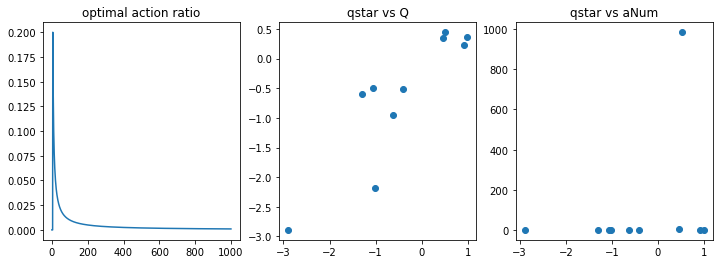

In [25]:
nStep = 1000
epsilon = 0
qstar   = np.random.randn(10)
print(qstar)
a,aNum,r,Q,optRatio = k_armed_bandit_one_run(qstar,epsilon,nStep, Qinit=np.ones(K)*5)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(optRatio)
ax[1].scatter(qstar,Q)
ax[2].scatter(qstar,aNum)
ax[0].set_title('optimal action ratio')
ax[1].set_title('qstar vs Q')
ax[2].set_title('qstar vs aNum')

In [8]:
print(aNum)
print(qstar)

[  1   1   1   1   1   1   1   1   1 991]
[ 1.31145117  0.383859   -1.40324447 -0.189382   -2.28145394 -0.93950005
 -1.07787184  0.19357217 -0.5169025   0.87406999]


In [11]:
for k in range(10):
    print(np.random.randn(10))

[-7.47272049e-01  6.81007444e-01 -2.90762307e+00 -2.67582699e+00
  2.63055633e-03  7.15296887e-01  1.59394774e+00 -1.95482283e-01
 -4.01726595e-01 -1.09224178e+00]
[ 0.54546269 -0.5124545  -1.45311658  0.2827805   0.46638545  1.1901648
  0.18343371 -0.173209    0.78758937  1.91271234]
[-0.42522844 -0.66267506 -0.52712828 -0.57616723  0.4474997   0.13282791
 -0.16560643 -0.73159231  1.08223244 -0.56805124]
[ 1.79478114 -0.17925689 -1.11522583 -1.62036343  0.17851929  1.09773418
 -1.25304687 -0.45924698 -0.82478145  0.73591023]
[ 0.46717646 -1.67353966  0.11164671 -0.49240837  0.39198933  0.42229428
  1.03114967 -0.13342255  0.58318588  1.86191985]
[ 0.24930518 -0.00658401 -0.21893969  0.45326183 -0.16374319 -0.11865037
 -0.67977221 -1.29616701  1.62325267 -1.68211812]
[ 2.22222498 -1.10849064  0.26855889  1.15770305 -0.60080041 -0.3466683
 -0.1195894  -0.92749375  0.16719596  0.1421029 ]
[-2.06180055  0.24464948 -0.95332416 -0.17671051  1.64967985  0.79137726
  0.97041119  1.21426357  0

## 仿真确认Q初始值的影响--sample average method

In [26]:
nStep = 1000
nRun  = 2000
K     = 10

r_0p0_Q5   = np.zeros((nRun,nStep+1))
r_0p1_Q0   = np.zeros((nRun,nStep+1))
optRatio_0p0_Q5 = np.zeros((nRun,nStep+1))
optRatio_0p1_Q0 = np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10)     
    a,aNum,r_0p0_Q5[run,:],Q,optRatio_0p0_Q5[run,:] = k_armed_bandit_one_run(qstar,epsilon=0,nStep=nStep, Qinit=np.ones(K)*5)
    a,aNum,r_0p1_Q0[run,:],Q,optRatio_0p1_Q0[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.1,nStep=nStep, Qinit=np.zeros(K))


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

Text(0.5, 1.0, 'Optional action selection ratio')

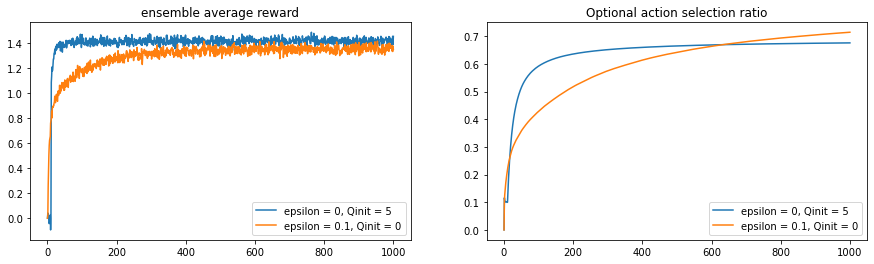

In [28]:
rEnsembleMean_0p0_Q5 = np.mean(r_0p0_Q5,axis=0)
rEnsembleMean_0p1_Q0 = np.mean(r_0p1_Q0,axis=0)

optRatioEnsembleMean_0p0_Q5 = np.mean(optRatio_0p0_Q5,axis=0)
optRatioEnsembleMean_0p1_Q0 = np.mean(optRatio_0p1_Q0,axis=0)


fig,ax = plt.subplots(1,2,figsize=(15,4))

ax[0].plot(rEnsembleMean_0p0_Q5)  # Without time-domain smooth filtering
ax[0].plot(rEnsembleMean_0p1_Q0)
ax[0].legend(['epsilon = 0, Qinit = 5','epsilon = 0.1, Qinit = 0'])
ax[0].set_title('ensemble average reward')

ax[1].plot(optRatioEnsembleMean_0p0_Q5)
ax[1].plot(optRatioEnsembleMean_0p1_Q0)
ax[1].legend(['epsilon = 0, Qinit = 5','epsilon = 0.1, Qinit = 0'])
ax[1].set_title('Optional action selection ratio')

## 仿真确认Q初始值的影响--Constant step-size alpha = 0.1


In [29]:
nStep = 1000
nRun  = 2000
K     = 10

r_0p0_Q5   = np.zeros((nRun,nStep+1))
r_0p1_Q0   = np.zeros((nRun,nStep+1))
optRatio_0p0_Q5 = np.zeros((nRun,nStep+1))
optRatio_0p1_Q0 = np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10)     
    a,aNum,r_0p0_Q5[run,:],Q,optRatio_0p0_Q5[run,:] = k_armed_bandit_one_run(qstar,epsilon=0,nStep=nStep,QUpdtAlgo='exp_decaying',alpha=0.1, Qinit=np.ones(K)*5)
    a,aNum,r_0p1_Q0[run,:],Q,optRatio_0p1_Q0[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.1,nStep=nStep,QUpdtAlgo='exp_decaying',alpha=0.1, Qinit=np.zeros(K))


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

Text(0.5, 1.0, 'Optional action selection ratio')

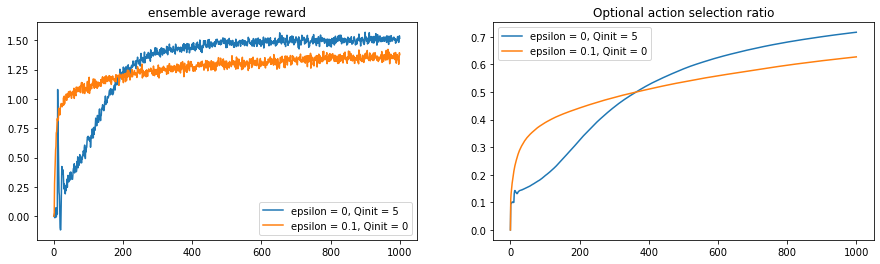

In [30]:
rEnsembleMean_0p0_Q5 = np.mean(r_0p0_Q5,axis=0)
rEnsembleMean_0p1_Q0 = np.mean(r_0p1_Q0,axis=0)

optRatioEnsembleMean_0p0_Q5 = np.mean(optRatio_0p0_Q5,axis=0)
optRatioEnsembleMean_0p1_Q0 = np.mean(optRatio_0p1_Q0,axis=0)


fig,ax = plt.subplots(1,2,figsize=(15,4))

ax[0].plot(rEnsembleMean_0p0_Q5)  # Without time-domain smooth filtering
ax[0].plot(rEnsembleMean_0p1_Q0)
ax[0].legend(['epsilon = 0, Qinit = 5','epsilon = 0.1, Qinit = 0'])
ax[0].set_title('ensemble average reward')

ax[1].plot(optRatioEnsembleMean_0p0_Q5)
ax[1].plot(optRatioEnsembleMean_0p1_Q0)
ax[1].legend(['epsilon = 0, Qinit = 5','epsilon = 0.1, Qinit = 0'])
ax[1].set_title('Optional action selection ratio')